# EA-RoBERTa: Emotion-Aware RoBERTa with ESA + TF-IDF Gating


In [ ]:
import os
import re
import json
from typing import Optional, Dict, List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, matthews_corrcoef, classification_report
)
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler

from transformers import (
    RobertaTokenizerFast, RobertaModel,
    TrainingArguments, Trainer
)
from transformers.modeling_outputs import SequenceClassifierOutput

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.2 GB


## 1. Configuration

In [ ]:
# DATA_DIR = "../database_used_by_paper"
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = "/content/drive/MyDrive/EA_RoBERTa/database_used_by_paper"

TRAIN_PATH = os.path.join(DATA_DIR, 'train.txt')
VAL_PATH = os.path.join(DATA_DIR, 'val.txt')
TEST_PATH = os.path.join(DATA_DIR, 'test.txt')

# =============================================================================
# MODEL CONFIGURATION (from paper)
# =============================================================================
CONFIG = {
    'model_name': 'roberta-base',
    'max_length': 128,
    'batch_size': 16,
    'learning_rate': 1e-5,
    'num_epochs': 10,
    'dropout': 0.3,
    'weight_decay': 0.01,
    'warmup_ratio': 0.1,
    'seed': 42,
    # TF-IDF settings
    'tfidf_threshold': 3.5,
    'tfidf_min_tokens': 4,
    # Gating
    'use_tfidf_gating': True
}

# Create output directories
os.makedirs('models/ea_roberta', exist_ok=True)
os.makedirs('reports', exist_ok=True)

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

Mounted at /content/drive
Configuration:
  model_name: roberta-base
  max_length: 128
  batch_size: 16
  learning_rate: 1e-05
  num_epochs: 10
  dropout: 0.3
  weight_decay: 0.01
  warmup_ratio: 0.1
  seed: 42
  tfidf_threshold: 3.5
  tfidf_min_tokens: 4
  use_tfidf_gating: True


## 2. Data Loading

In [ ]:
def load_emotion_data(file_path, sep=';'):
    """Load emotion data from text file."""
    texts, labels = [], []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split(sep, 1)
            if len(parts) == 2:
                texts.append(parts[0].strip())
                labels.append(parts[1].strip())
    return pd.DataFrame({'text': texts, 'label_str': labels})

# Load splits
print("Loading data...")
train_df_raw = load_emotion_data(TRAIN_PATH)
val_df_raw = load_emotion_data(VAL_PATH)
test_df_raw = load_emotion_data(TEST_PATH)

print(f"✅ Data loaded:")
print(f"   Train: {len(train_df_raw):,}")
print(f"   Val:   {len(val_df_raw):,}")
print(f"   Test:  {len(test_df_raw):,}")

Loading data...
✅ Data loaded:
   Train: 16,000
   Val:   2,000
   Test:  2,000


## 3. Text Preprocessing (Slang-Aware)

In [ ]:
SLANG_MAP = {
    # Common abbreviations
    "u": "you", "ur": "your", "r": "are", "n": "and", "b": "be", "c": "see", "y": "why",
    "k": "okay", "ok": "okay", "pls": "please", "plz": "please", "thx": "thanks", "thnx": "thanks",
    "ty": "thank you", "bc": "because", "cuz": "because", "bcuz": "because", "bcoz": "because",
    "cos": "because", "coz": "because","w": "with", "wo": "without", "abt": "about", "bout": "about",
    "bf": "boyfriend", "gf": "girlfriend", "bff": "best friend", "rn": "right now",
    "imo": "in my opinion", "imho": "in my humble opinion", "tbh": "to be honest",
    "fyi": "for your information", "btw": "by the way", "afaik": "as far as i know",
    "irl": "in real life", "jk": "just kidding", "omw": "on my way", "brb": "be right back",
    "gtg": "got to go", "g2g": "got to go", "ttyl": "talk to you later", "nvm": "never mind",
    "idk": "i do not know", "idc": "i do not care", "idgaf": "i do not care", "dm": "direct message",
    "rt": "retweet", "fb": "facebook", "ig": "instagram", "yt": "youtube", "smh": "shaking my head",
    "fomo": "fear of missing out", "yolo": "you only live once", "bae": "babe", "fam": "family",
    "lit": "exciting", "slay": "amazing", "goat": "greatest of all time", "af": "very",
    "asf": "very", "lowkey": "somewhat", "highkey": "very", "srsly": "seriously", "tho": "though",
    "thru": "through", "kinda": "kind of", "sorta": "sort of", "gonna": "going to",
    "wanna": "want to", "gotta": "got to", "coulda": "could have", "shoulda": "should have",
    "woulda": "would have", "musta": "must have", "lemme": "let me", "gimme": "give me",
    "dunno": "do not know", "whatcha": "what are you", "gotcha": "got you", "outta": "out of", "lotta": "lot of",
    "lotsa": "lots of", "kinda": "kind of", "innit": "is it not", "aint": "is not", "ain't": "is not",
    "yall": "you all", "y'all": "you all",

    # Emotion-related expressions
    "lol": "laughing", "lmao": "laughing", "lmfao": "laughing", "rofl": "laughing",
    "roflmao": "laughing", "haha": "laughing", "hahaha": "laughing", "hehe": "laughing",
    "hihi": "laughing", "xd": "laughing", "xD": "laughing", "omg": "oh my god", "omfg": "oh my god",
    "wtf": "what the heck", "wth": "what the heck", "stfu": "shut up", "ugh": "frustrated",
    "meh": "indifferent", "oof": "ouch", "yikes": "shocked", "eww": "disgusted", "aww": "touched",
    "yay": "excited", "woohoo": "excited", "woah": "surprised", "whoa": "surprised",
    "wow": "surprised", "damn": "frustrated", "dammit": "frustrated", "damnit": "frustrated",

    # Missing apostrophe contractions
    "im": "i am", "ive": "i have", "id": "i would", "ill": "i will", "youre": "you are",
    "youve": "you have", "youd": "you would", "youll": "you will", "hes": "he is",
    "shes": "she is", "thats": "that is", "whats": "what is", "whos": "who is",
    "wheres": "where is", "heres": "here is", "theres": "there is", "theyre": "they are",
    "theyve": "they have", "theyd": "they would", "theyll": "they will", "weve": "we have",
    "wed": "we would", "dont": "do not", "doesnt": "does not", "didnt": "did not",
    "wont": "will not", "wouldnt": "would not", "couldnt": "could not", "shouldnt": "should not",
    "cant": "cannot", "cannot": "can not", "isnt": "is not", "arent": "are not",
    "wasnt": "was not", "werent": "were not", "hasnt": "has not", "havent": "have not",
    "hadnt": "had not", "mustnt": "must not", "lets": "let us",
}

EMOTICON_MAP = {
    ":)": " happy ", ":(": " sad ", ":D": " very happy ", ":-)": " happy ", ":-(": " sad ",
    ";)": " playful ", ";-)": " playful ", ":p": " playful ", ":P": " playful ", ":-p": " playful ",
    ":-P": " playful ", ":o": " surprised ", ":O": " surprised ", ":-o": " surprised ",
    ":-O": " surprised ", ":/": " unsure ", ":-/": " unsure ", ":\\": " unsure ", ":-\\": " unsure ",
    "<3": " love ", "</3": " heartbroken ", "xo": " love ", "xoxo": " love ",
}

NEGATION_WHITELIST = {"not", "no", "never", "n't", "none", "nothing", "nowhere"}
INTENSIFIERS = {"very", "so", "too", "really", "extremely", "quite"}

def normalize_elongated_words(text):
    """
    Reduce elongated characters to max 2 repetitions.
    'soooooo' -> 'soo', 'happyyy' -> 'happyy'
    This preserves some emphasis while normalizing.
    """

    return re.sub(r'(.)\1{2,}', r'\1\1', text)

def replace_slang(text):
    """
    Replace slang/abbreviations with full forms.
    Uses word boundaries to avoid partial replacements.
    """

    words = text.split()
    result = []
    for word in words:
        word_lower = word.lower()
        if word_lower in SLANG_MAP:
            result.append(SLANG_MAP[word_lower])
        else:
            result.append(word)
    return ' '.join(result)

def replace_emoticons(text):
    """Replace text emoticons with emotion words."""

    for emoticon, replacement in EMOTICON_MAP.items():
        text = text.replace(emoticon, replacement)
    return text

def replace_emoticons(text):
    """Replace text emoticons with emotion words."""

    for emoticon, replacement in EMOTICON_MAP.items():
        text = text.replace(emoticon, replacement)
    return text

def clean_text(text):
    """Comprehensive text cleaning for social media data."""

    if not isinstance(text, str):
        return ""

    # 1. Replace emoticons with emotion words (before stripping special chars)
    text = replace_emoticons(text)

    # 2. Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # 3. Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # 4. Convert hashtags to words (#happy -> happy)
    text = re.sub(r'#(\w+)', r'\1', text)

    # 5. Normalize elongated words (soooo -> soo)
    text = normalize_elongated_words(text)

    # 6. Replace slang and abbreviations
    text = replace_slang(text)

    # 7. Remove special characters but keep emotional punctuation
    # Keep: letters, numbers, spaces, and ! ? . , ' - "
    text = re.sub(r"[^a-zA-Z0-9\s!?.,;:'\"\-]", '', text)

    # 8. Normalize repeated punctuation (!!!! -> !!)
    text = re.sub(r'([!?.]){2,}', r'\1\1', text)

    # 9. Normalize whitespace
    text = re.sub(r'\s+', ' ', text)

    # 10. Strip and lowercase
    text = text.strip().lower()

    return text

print(f"Loaded {len(SLANG_MAP)} slang + {len(EMOTICON_MAP)} emoticon mappings")

Loaded 157 slang + 23 emoticon mappings


In [ ]:
train_labels = sorted(train_df_raw['label_str'].unique())
label_to_id = {label: idx for idx, label in enumerate(train_labels)}
id_to_label = {idx: label for label, idx in label_to_id.items()}
NUM_LABELS = len(train_labels)

print("Label Mapping (built from TRAIN only):")
print("-" * 40)
for label, idx in label_to_id.items():
    count = len(train_df_raw[train_df_raw['label_str'] == label])
    print(f"  {idx}: {label:10s} ({count:,} train samples)")

def preprocess_df(df):
    df = df.copy()
    df['text'] = df['text'].apply(clean_text)
    df['label'] = df['label_str'].map(label_to_id)
    df = df[df['text'].str.len() > 0].reset_index(drop=True)
    return df

train_df = preprocess_df(train_df_raw)
val_df = preprocess_df(val_df_raw)
test_df = preprocess_df(test_df_raw)

print(f"\n✅ Preprocessing complete:")
print(f"   Train: {len(train_df):,}")
print(f"   Val:   {len(val_df):,}")
print(f"   Test:  {len(test_df):,}")

Label Mapping (built from TRAIN only):
----------------------------------------
  0: anger      (2,159 train samples)
  1: fear       (1,937 train samples)
  2: joy        (5,362 train samples)
  3: love       (1,304 train samples)
  4: sadness    (4,666 train samples)
  5: surprise   (572 train samples)

✅ Preprocessing complete:
   Train: 16,000
   Val:   2,000
   Test:  2,000


## 4. Oversampling

In [ ]:
print("Before oversampling:")
print(train_df['label_str'].value_counts())

ros = RandomOverSampler(random_state=CONFIG['seed'])
X_resampled, y_resampled = ros.fit_resample(
    train_df['text'].values.reshape(-1, 1),
    train_df['label'].values
)

train_df_os = pd.DataFrame({
    'text': X_resampled.flatten(),
    'label': y_resampled
})
train_df_os['label_str'] = train_df_os['label'].map(id_to_label)

print(f"\nAfter oversampling:")
print(train_df_os['label_str'].value_counts())
print(f"\n✅ {len(train_df):,} -> {len(train_df_os):,} samples")

Before oversampling:
label_str
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

After oversampling:
label_str
sadness     5362
anger       5362
love        5362
surprise    5362
fear        5362
joy         5362
Name: count, dtype: int64

✅ 16,000 -> 32,172 samples


## 5. TF-IDF Gating Mechanism

In [ ]:
def regex_analyzer(text):
    text = text.lower()
    return re.findall(r"(?u)\b\w+\b", text)

class TFIDFGating:
    """TF-IDF gating as described in the EA-RoBERTa paper."""

    def __init__(self, threshold=3.5, min_tokens=4):
        self.threshold = threshold
        self.min_tokens = min_tokens
        self.vectorizer = TfidfVectorizer( norm=None, analyzer=regex_analyzer )
        self._is_fitted = False

    def fit(self, texts):
        print(f"Fitting TF-IDF on {len(texts):,} samples...")

        self.vectorizer.fit(texts)
        self._is_fitted = True
        print(f"  Vocabulary: {len(self.vectorizer.vocabulary_):,} words")
        return self

    def get_word_scores(self, text):

        analyzer = self.vectorizer.build_analyzer()
        words = analyzer(text)
        if not words:
            return [], np.array([])

        tfidf = self.vectorizer.transform([text.lower()])
        vocab = self.vectorizer.vocabulary_

        scores = []
        for word in words:
            idx = vocab.get(word)
            scores.append(float(tfidf[0, idx]) if idx is not None else 0.0)

        return words, np.array(scores, dtype=np.float32)

    def compute_gates(self, text, normalize=True):
      words, scores = self.get_word_scores(text)
      if len(words) == 0:
          return words, np.array([])

      keep = scores >= self.threshold
      if keep.sum() < self.min_tokens:
          if len(scores) >= self.min_tokens:
              top_k = np.argsort(-scores)[:self.min_tokens]
              keep = np.zeros_like(keep, dtype=bool)
              keep[top_k] = True
          else:
              keep = np.ones_like(keep, dtype=bool)

      gates = scores.copy()
      gates[~keep] = 0.0

      if normalize and gates.max() > 0:
          gates = gates / gates.max()

      return words, gates.astype(np.float32)

    def get_stats(self, texts):
          """Get filtering statistics."""

          orig_lens, filt_lens = [], []
          for text in texts:
              words, scores = self.get_word_scores(text)
              if len(words) == 0:
                  continue

              # Apply same logic as compute_gates
              keep = scores >= self.threshold
              if keep.sum() < self.min_tokens:
                  if len(scores) >= self.min_tokens:
                      top_k = np.argsort(-scores)[:self.min_tokens]
                      keep = np.zeros_like(keep, dtype=bool)
                      keep[top_k] = True
                  else:
                      keep = np.ones_like(keep, dtype=bool)

              orig_lens.append(len(words))
              filt_lens.append(keep.sum())

          return {
              'avg_original': np.mean(orig_lens),
              'avg_filtered': np.mean(filt_lens),
              'avg_retention': np.mean([f/o if o > 0 else 1 for o, f in zip(orig_lens, filt_lens)])
          }

# Fit TF-IDF on oversampled train data
tfidf_gating = TFIDFGating( threshold=CONFIG['tfidf_threshold'], min_tokens=CONFIG['tfidf_min_tokens'] )
tfidf_gating.fit(train_df_os['text'].tolist())

Fitting TF-IDF on 32,172 samples...
  Vocabulary: 15,087 words


In [ ]:
print("TFIDF fitted?", getattr(tfidf_gating, "_is_fitted", None))
print("TFIDF vocab size:", len(tfidf_gating.vectorizer.vocabulary_))

sample_text = "Love this moment, it brings happiness."
words, gates = tfidf_gating.compute_gates(sample_text, normalize=True)
print(list(zip(words, gates))[:15])
print("gates min/max:", gates.min() if len(gates) else None, gates.max() if len(gates) else None)


TFIDF fitted? True
TFIDF vocab size: 15087
[('love', np.float32(0.5585911)), ('this', np.float32(0.0)), ('moment', np.float32(0.70048916)), ('it', np.float32(0.0)), ('brings', np.float32(1.0)), ('happiness', np.float32(0.97064185))]
gates min/max: 0.0 1.0


In [ ]:
print("\nFiltering Statistics:")
print("=" * 40)

for name, df in [('Train (OS)', train_df_os), ('Val', val_df), ('Test', test_df)]:
    stats = tfidf_gating.get_stats(df['text'].tolist())
    print(f"{name}:")
    print(f"  Avg words before: {stats['avg_original']:.1f}")
    print(f"  Avg words after:  {stats['avg_filtered']:.1f}")
    print(f"  Retention rate:   {stats['avg_retention']*100:.1f}%")
    print()


Filtering Statistics:
Train (OS):
  Avg words before: 19.6
  Avg words after:  13.2
  Retention rate:   64.4%

Val:
  Avg words before: 19.2
  Avg words after:  12.3
  Retention rate:   61.8%

Test:
  Avg words before: 19.5
  Avg words after:  12.6
  Retention rate:   61.8%



## 6. Dataset & DataLoader

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained(CONFIG['model_name'])
print(f"Tokenizer: {CONFIG['model_name']}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Tokenizer: roberta-base


In [ ]:
class EmotionDataset(Dataset):
    """Dataset with TF-IDF gate computation."""

    def __init__(self, texts, labels, tokenizer, tfidf_gating=None, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.tfidf_gating = tfidf_gating
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding=False,
            return_offsets_mapping=True,
            return_tensors=None
        )

        item = {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'labels': label
        }

        # Compute gates if TF-IDF gating is enabled
        if self.tfidf_gating is not None:
            words, word_gates = self.tfidf_gating.compute_gates(text)
            token_gates = self._map_gates_to_tokens(
                text, words, word_gates, encoding['offset_mapping']
            )
            item['gates'] = token_gates

        return item

    def _map_gates_to_tokens(self, text, words, word_gates, offsets):
        """Map word-level gates to subtoken level."""
        seq_len = len(offsets)
        token_gates = [1.0] * seq_len  # Default: 1.0 (no suppression)

        if len(words) == 0:
            return token_gates

        # Build word character spans
        word_spans = []
        pos = 0
        text_lower = text.lower()
        for word in words:
            start = text_lower.find(word, pos)
            if start != -1:
                word_spans.append((start, start + len(word)))
                pos = start + len(word)
            else:
                word_spans.append(None)

        # Map tokens to words
        for token_idx, (char_start, char_end) in enumerate(offsets):
            if char_start == char_end:  # Special token
                token_gates[token_idx] = 1.0
                continue

            for word_idx, span in enumerate(word_spans):
                if span is None:
                    continue
                ws, we = span
                # Check overlap
                if not (char_end <= ws or char_start >= we):
                    token_gates[token_idx] = float(word_gates[word_idx])
                    break

        return token_gates

In [ ]:
class DataCollatorWithGates:
    """Collator that pads both tokens and gates."""

    def __init__(self, tokenizer):
        self.pad_id = tokenizer.pad_token_id

    def __call__(self, features):
        max_len = max(len(f['input_ids']) for f in features)

        batch = {'input_ids': [], 'attention_mask': [], 'labels': []}
        has_gates = 'gates' in features[0]
        if has_gates:
            batch['gates'] = []

        for f in features:
            pad_len = max_len - len(f['input_ids'])
            batch['input_ids'].append(f['input_ids'] + [self.pad_id] * pad_len)
            batch['attention_mask'].append(f['attention_mask'] + [0] * pad_len)
            batch['labels'].append(f['labels'])
            if has_gates:
                batch['gates'].append(f['gates'] + [0.0] * pad_len)

        batch['input_ids'] = torch.tensor(batch['input_ids'], dtype=torch.long)
        batch['attention_mask'] = torch.tensor(batch['attention_mask'], dtype=torch.long)
        batch['labels'] = torch.tensor(batch['labels'], dtype=torch.long)
        if has_gates:
            batch['gates'] = torch.tensor(batch['gates'], dtype=torch.float32)

        return batch

In [ ]:
# Create datasets
gating = tfidf_gating if CONFIG['use_tfidf_gating'] else None

train_dataset = EmotionDataset( train_df_os['text'].tolist(), train_df_os['label'].tolist(), tokenizer, gating, CONFIG['max_length'] )
val_dataset = EmotionDataset( val_df['text'].tolist(), val_df['label'].tolist(), tokenizer, gating, CONFIG['max_length'] )
test_dataset = EmotionDataset( test_df['text'].tolist(), test_df['label'].tolist(), tokenizer, gating, CONFIG['max_length'] )
data_collator = DataCollatorWithGates(tokenizer)

print(f"✅ Datasets created:")
print(f"   Train: {len(train_dataset):,}")
print(f"   Val:   {len(val_dataset):,}")
print(f"   Test:  {len(test_dataset):,}")
print(f"   TF-IDF gating: {CONFIG['use_tfidf_gating']}")

✅ Datasets created:
   Train: 32,172
   Val:   2,000
   Test:  2,000
   TF-IDF gating: True


## 7. EA-RoBERTa Model (ESA + TF-IDF Gating)

In [ ]:
class ESALayer(nn.Module):
    """
    Emotion-Specific Attention Layer.

    From paper: "The ESA layer introduces emotion-aware weighting by learning
    an emotion-specific importance vector that modulates attention distribution."
    """

    def __init__(self, hidden_dim: int, num_heads: int = 12, max_len: int = 512):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.max_len = max_len

        # Learned positional encoding P ∈ R[max_len, H]
        self.pos_emb = nn.Embedding(max_len, hidden_dim)

        # Multi-head attention
        self.mha = nn.MultiheadAttention( embed_dim=hidden_dim, num_heads=num_heads, batch_first=True )

        # Learnable scaling vector S (emotion-specific importance)
        self.S = nn.Parameter(torch.ones(hidden_dim))

    def forward(self, E, attention_mask=None):
        """
        Args:
            E: [B, L, H] - RoBERTa embeddings
            attention_mask: [B, L] - 1=real, 0=pad
        Returns:
            Z_final: [B, L, H] - ESA-refined embeddings
        """
        B, L, H = E.shape

        # Add positional encoding
        positions = torch.arange(L, device=E.device).unsqueeze(0).expand(B, L)
        P = self.pos_emb(positions)
        E_input = E + P

        # Create key padding mask for MHA (True = ignore)
        key_padding_mask = None
        if attention_mask is not None:
            key_padding_mask = (attention_mask == 0)

        # Self-attention
        Z, attention_weights = self.mha(
            E_input, E_input, E_input,
            key_padding_mask=key_padding_mask,
            need_weights=True,
            average_attn_weights=False
        )

        # Emotion-specific scaling
        Z_scaled = Z * self.S

        # Re-add positional encoding
        Z_final = Z_scaled + P

        return Z_final, attention_weights

In [ ]:
class EARoBERTa(nn.Module):
    """
    Emotion-Aware RoBERTa with:
    - TF-IDF gating (modulates embeddings)
    - ESA layer (emotion-specific attention)
    - CLS + Mean pooling
    """

    def __init__(self, model_name, num_labels, dropout=0.3, use_gates=True, dense_dim=256):
        super().__init__()

        self.num_labels = num_labels
        self.use_gates = use_gates

        # RoBERTa backbone
        self.roberta = RobertaModel.from_pretrained(model_name)
        cfg = self.roberta.config
        hidden_size = self.roberta.config.hidden_size

        # ESA layer
        self.esa = ESALayer(
            hidden_dim=hidden_size,
            num_heads=cfg.num_attention_heads,
            max_len=cfg.max_position_embeddings
        )

        # Classification head
        self.dropout = nn.Dropout(dropout)
        self.dense = nn.Sequential(
            nn.Linear(2 * hidden_size, dense_dim),  # CLS + Mean
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.classifier = nn.Linear(dense_dim, num_labels)

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids=None, attention_mask=None, labels=None, inputs_embeds=None, gates=None, **kwargs):
        assert attention_mask is not None, "attention_mask is required"

        # Apply TF-IDF gating to embeddings
        if self.use_gates and inputs_embeds is None and input_ids is not None and gates is not None:
            word_embeds = self.roberta.embeddings.word_embeddings(input_ids)
            gates = gates.unsqueeze(-1).type_as(word_embeds)                  # [B,L,1]
            inputs_embeds = word_embeds * gates
            input_ids = None   # cannot pass both

        # Get RoBERTa embeddings
        outputs = self.roberta(
            input_ids=input_ids,
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            return_dict=True
        )

        E = outputs.last_hidden_state  # [B, L, H]

        # Apply ESA layer
        Z, _ = self.esa(E, attention_mask)

        # Pooling: CLS + Mean
        cls_output = Z[:, 0, :]  # [B, H]

        # Masked mean pooling
        mask = attention_mask.unsqueeze(-1).type_as(Z)  # [B, L, 1]
        mean_output = (Z * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)

        pooled = torch.cat([cls_output, mean_output], dim=-1)  # [B, 2H]

        # Classification
        pooled = self.dropout(pooled)
        hidden = self.dense(pooled)
        logits = self.classifier(hidden)

        # Compute loss
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return SequenceClassifierOutput( loss=loss, logits=logits )

In [ ]:
# Create model
model = EARoBERTa(
    model_name=CONFIG['model_name'],
    num_labels=NUM_LABELS,
    dropout=CONFIG['dropout'],
    use_gates=CONFIG['use_tfidf_gating'],
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✅ EA-RoBERTa created on {device}")
print(f"   Total params: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")
print(f"   TF-IDF gating: {CONFIG['use_tfidf_gating']}")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✅ EA-RoBERTa created on cuda
   Total params: 127,798,534
   Trainable: 127,798,534
   TF-IDF gating: True


In [ ]:
# Test forward pass
model.train()
batch = next(iter(DataLoader(train_dataset, batch_size=4, collate_fn=data_collator)))
batch = {k: v.to(device) for k, v in batch.items()}

with torch.no_grad():
    out = model(**batch)

print(f"✅ Forward pass OK")
print(f"   Logits: {out.logits.shape}")
print(f"   Loss: {out.loss.item():.4f}")

✅ Forward pass OK
   Logits: torch.Size([4, 6])
   Loss: 1.8670


## 8. Training

In [ ]:
def compute_metrics(eval_pred):
    """Compute evaluation metrics."""

    predictions, labels = eval_pred
    if isinstance(predictions, tuple): predictions = predictions[0]
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support( labels, predictions, average='weighted' )
    mcc = matthews_corrcoef(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1_weighted': f1,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'mcc': mcc
    }

print("✅ Metrics function defined")

✅ Metrics function defined


In [ ]:
training_args = TrainingArguments(
    output_dir='./results/ea_roberta',

    # Training
    num_train_epochs=CONFIG['num_epochs'],
    per_device_train_batch_size=CONFIG['batch_size'],
    per_device_eval_batch_size=CONFIG['batch_size'],
    learning_rate=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
    warmup_ratio=CONFIG['warmup_ratio'],

    # Evaluation
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1_weighted',
    greater_is_better=True,

    # Logging
    logging_dir='./logs/ea_roberta',
    logging_steps=100,

    # Optimization
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=4,
    remove_unused_columns=False,

    # Other
    report_to='none',
    seed=CONFIG['seed'],
    save_total_limit=2
)

print("✅ Training arguments configured")

✅ Training arguments configured


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("✅ Trainer created")
print(f"   Train batches: {len(train_dataset) // CONFIG['batch_size']:,}")
print(f"   Total steps: {len(train_dataset) // CONFIG['batch_size'] * CONFIG['num_epochs']:,}")

✅ Trainer created
   Train batches: 2,010
   Total steps: 20,100


In [ ]:
print("=" * 60)
print(" STARTING EA-RoBERTa TRAINING")
print("=" * 60)
print(f"   Device: {device}")
print(f"   Epochs: {CONFIG['num_epochs']}")
print(f"   Batch size: {CONFIG['batch_size']}")
print(f"   Learning rate: {CONFIG['learning_rate']}")
print(f"   TF-IDF Gating: {CONFIG['use_tfidf_gating']}")
print("=" * 60)

train_result = trainer.train()

print("\n✅ Training complete!")
print(f"   Loss: {train_result.training_loss:.4f}")
print(f"   Time: {train_result.metrics['train_runtime']:.1f}s")

 STARTING EA-RoBERTa TRAINING
   Device: cuda
   Epochs: 10
   Batch size: 16
   Learning rate: 1e-05
   TF-IDF Gating: True


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,Mcc
1,0.384400,0.519309,0.882500,0.884377,0.895561,0.882500,0.850448
2,0.256900,0.406612,0.905000,0.906771,0.914424,0.905000,0.878261
3,0.165800,0.396574,0.912500,0.913667,0.918823,0.912500,0.887142
4,0.156700,0.468738,0.905500,0.907476,0.914826,0.905500,0.879005
5,0.147100,0.503992,0.913000,0.914137,0.916985,0.913000,0.886866
6,0.084400,0.535077,0.916000,0.916849,0.920180,0.916000,0.890856
7,0.077700,0.664966,0.908000,0.908943,0.911370,0.908000,0.880267
8,0.050000,0.653549,0.912500,0.913022,0.914034,0.912500,0.885548
9,0.061900,0.664388,0.918500,0.918962,0.919928,0.918500,0.893367
10,0.012800,0.680998,0.916500,0.917024,0.917926,0.916500,0.890731



✅ Training complete!
   Loss: 0.2107
   Time: 988.9s


In [ ]:
model.eval()
batch_dev = {k: v.to(device) for k, v in batch.items()}

with torch.no_grad():
    out_g = model(**batch_dev)

batch_ones = dict(batch_dev)
batch_ones["gates"] = torch.ones_like(batch_dev["gates"])

with torch.no_grad():
    out_1 = model(**batch_ones)

diff = (out_g.logits - out_1.logits).abs().mean().item()
print("Mean |logit diff| (gates vs ones):", diff)


Mean |logit diff| (gates vs ones): 1.02157723903656


In [ ]:
# Save model
trainer.save_model('./models/ea_roberta')
tokenizer.save_pretrained('./models/ea_roberta')

# Save config
with open('./models/ea_roberta/config.json', 'w') as f:
    json.dump(CONFIG, f, indent=2)

print("✅ Model saved to ./models/ea_roberta/")

✅ Model saved to ./models/ea_roberta/


## 9. Evaluation

In [ ]:
print("\n" + "=" * 60)
print("📊 EVALUATION")
print("=" * 60)

# Validation
val_results = trainer.evaluate(val_dataset)
print("\nValidation:")
for k, v in val_results.items():
    if isinstance(v, float):
        print(f"   {k}: {v:.4f}")

# Test
test_results = trainer.evaluate(test_dataset)
print("\nTest:")
for k, v in test_results.items():
    if isinstance(v, float):
        print(f"   {k}: {v:.4f}")


📊 EVALUATION



Validation:
   eval_loss: 0.6644
   eval_accuracy: 0.9185
   eval_f1_weighted: 0.9190
   eval_precision_weighted: 0.9199
   eval_recall_weighted: 0.9185
   eval_mcc: 0.8934
   eval_runtime: 2.4257
   eval_samples_per_second: 824.5160
   eval_steps_per_second: 51.5320
   epoch: 10.0000

Test:
   eval_loss: 0.6369
   eval_accuracy: 0.9130
   eval_f1_weighted: 0.9142
   eval_precision_weighted: 0.9166
   eval_recall_weighted: 0.9130
   eval_mcc: 0.8859
   eval_runtime: 2.3588
   eval_samples_per_second: 847.8730
   eval_steps_per_second: 52.9920
   epoch: 10.0000


In [ ]:
# Detailed analysis
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = np.array([test_dataset[i]['labels'] for i in range(len(test_dataset))])

# Classification report
label_names = [id_to_label[i] for i in range(NUM_LABELS)]
print("\n📋 Classification Report:")
print("-" * 60)
print(classification_report(y_true, y_pred, target_names=label_names))


📋 Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

       anger       0.92      0.92      0.92       275
        fear       0.89      0.90      0.90       224
         joy       0.95      0.91      0.93       695
        love       0.75      0.87      0.80       159
     sadness       0.95      0.94      0.95       581
    surprise       0.72      0.80      0.76        66

    accuracy                           0.91      2000
   macro avg       0.86      0.89      0.88      2000
weighted avg       0.92      0.91      0.91      2000



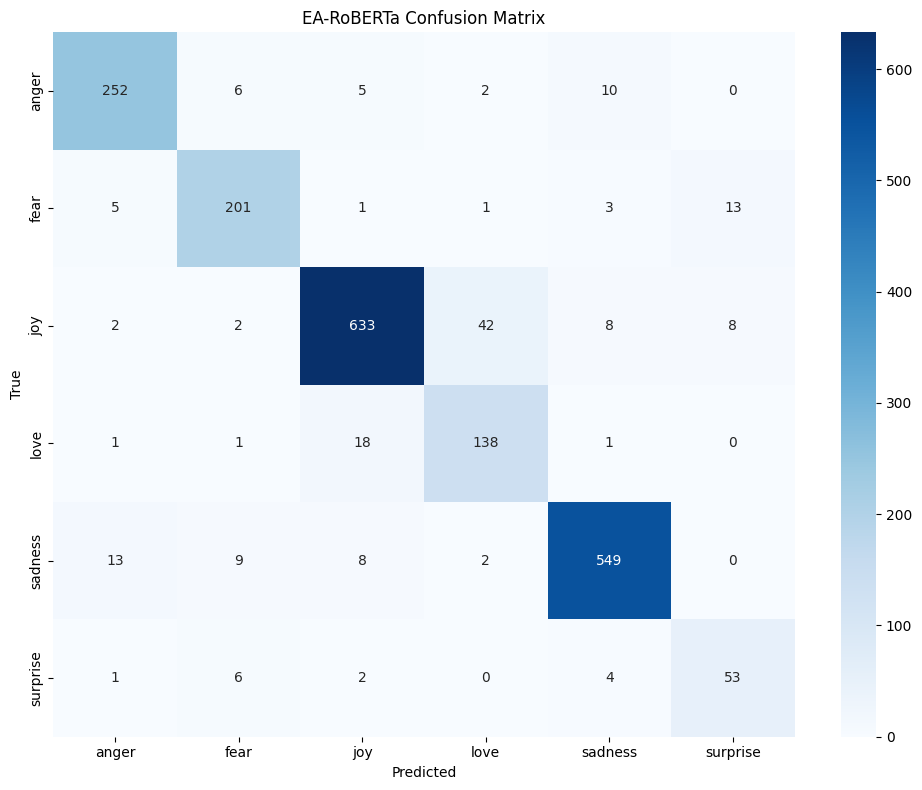

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=label_names, yticklabels=label_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('EA-RoBERTa Confusion Matrix')
plt.tight_layout()
plt.savefig('reports/ea_roberta_confusion_matrix.png', dpi=150)
plt.show()

In [ ]:
# Save results
results = {
    'config': CONFIG,
    'validation': {k: float(v) if isinstance(v, (float, np.floating)) else v
                   for k, v in val_results.items()},
    'test': {k: float(v) if isinstance(v, (float, np.floating)) else v
             for k, v in test_results.items()}
}

with open('reports/ea_roberta_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n" + "=" * 60)
print("📊 FINAL RESULTS")
print("=" * 60)
print(f"Test Accuracy:    {test_results['eval_accuracy']:.4f}")
print(f"Test F1 Weighted: {test_results['eval_f1_weighted']:.4f}")
print(f"Test MCC:         {test_results['eval_mcc']:.4f}")
print("=" * 60)


📊 FINAL RESULTS
Test Accuracy:    0.9130
Test F1 Weighted: 0.9142
Test MCC:         0.8859


# LIVE TESTING INTERFACE

### Word Importance Explainability (LOO Method)

In the interactive tester, explainability is implemented using a **text perturbation method** called **Leave-One-Out (LOO)**. The model is treated as a *black box* — we don’t inspect its internal layers, we only observe how its predictions change when the input is modified.

#### Steps of the method:

1. **Clean the text** (remove special characters, normalize the format).
2. **Tokenize the text** using the RoBERTa tokenizer.
3. **Compute TF-IDF gates externally** to assign an importance score to each word, and map those scores to the corresponding subtokens.
4. **Run the model on the full text** → this gives us the reference prediction score, also called **baseline emotion probability**.
5. **Remove one word at a time from the text**, rebuild the sentence without it, and send it again to the model.
6. **Recompute emotion probabilities** for the modified text.
7. **Calculate the importance of the removed word** as:

   ```
   importance = baseline_emotion_probability − emotion_probability_without_word
   ```

#### Score interpretation:

* **importance > 0** → the emotion probability **decreased** when the word was removed
  → meaning the word was **supporting that emotion**.
* **importance < 0** → the emotion probability **increased** when the word was removed
  → meaning the word was **suppressing or opposing that emotion**.
* **importance ≈ 0** → very small or no change
  → meaning the word had **minimal emotional impact (near-neutral)**.

#### Visualization in the UI:

* 🔴 **Red** = positive contribution (emotion-supporting)
* 🔵 **Blue** = negative contribution (emotion-blocking/opposing)
* ⚪ **Gray** = minimal or neutral impact

---

### Why use this method?

* It is **easy to understand and implement**
* It shows the **real measurable influence of each word on emotion probabilities**
* It is **gradient-free**, so it works for any model as a reliable **black-box explanation**
* This approach is widely used in explainability research and scientific papers



In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import torch
import numpy as np

class LiveEmotionTester:
    """Interactive single-label emotion tester with explainability."""

    def __init__(self, model, tokenizer, tfidf_gating, id_to_label, device, config):
        self.model = model
        self.tokenizer = tokenizer
        self.tfidf_gating = tfidf_gating
        self.id_to_label = id_to_label
        self.label_to_id = {v: k for k, v in id_to_label.items()}
        self.device = device
        self.config = config
        self.model.eval()

        self.emotion_colors = {
            'joy': '#FFD700',
            'love': '#FF69B4',
            'surprise': '#00CED1',
            'anger': '#FF4500',
            'sadness': '#4169E1',
            'fear': '#9932CC'
        }

    # =========================================================================
    # PREDICTION
    # =========================================================================
    def predict(self, text):
        """Predict emotion with confidence scores."""
        if not text.strip():
            return None, None, None, None

        cleaned = clean_text(text)
        words, gates = self.tfidf_gating.compute_gates(cleaned)

        encoding = self.tokenizer(
            cleaned,
            truncation=True,
            max_length=self.config['max_length'],
            padding='max_length',
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        gates_tensor = self._compute_token_gates(cleaned, encoding)

        with torch.no_grad():
            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                gates=gates_tensor
            )
            probs = torch.softmax(outputs.logits, dim=-1)[0]

        pred_idx = probs.argmax().item()
        pred_label = self.id_to_label[pred_idx]
        confidence = probs[pred_idx].item()
        all_probs = {self.id_to_label[i]: probs[i].item() for i in range(len(probs))}

        return pred_label, confidence, all_probs, (words, gates)

    def _compute_token_gates(self, text, encoding):
        """Compute gates aligned to tokens."""
        words, word_gates = self.tfidf_gating.compute_gates(text)
        seq_len = encoding['input_ids'].shape[1]
        token_gates = [1.0] * seq_len

        if len(words) == 0:
            return torch.tensor([token_gates], dtype=torch.float32).to(self.device)

        enc_with_offsets = self.tokenizer(
            text, return_offsets_mapping=True,
            truncation=True, max_length=self.config['max_length']
        )
        offsets = enc_with_offsets['offset_mapping']

        word_spans = []
        pos = 0
        text_lower = text.lower()
        for word in words:
            start = text_lower.find(word, pos)
            if start != -1:
                word_spans.append((start, start + len(word)))
                pos = start + len(word)
            else:
                word_spans.append(None)

        for token_idx, (char_start, char_end) in enumerate(offsets):
            if char_start == char_end:
                continue
            for word_idx, span in enumerate(word_spans):
                if span is None:
                    continue
                ws, we = span
                if not (char_end <= ws or char_start >= we):
                    token_gates[token_idx] = float(word_gates[word_idx])
                    break

        token_gates = token_gates + [0.0] * (self.config['max_length'] - len(token_gates))
        token_gates = token_gates[:self.config['max_length']]

        return torch.tensor([token_gates], dtype=torch.float32).to(self.device)

    # =========================================================================
    # WORD IMPORTANCE (Perturbation-based)
    # =========================================================================
    def _get_emotion_prob(self, text, emotion):
        """Get probability for a specific emotion."""
        if not text.strip():
            return 0.0

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.config['max_length'],
            padding='max_length',
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        gates_tensor = self._compute_token_gates(text, encoding)

        with torch.no_grad():
            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                gates=gates_tensor
            )
            probs = torch.softmax(outputs.logits, dim=-1)[0]

        target_idx = self.label_to_id[emotion]
        return probs[target_idx].item()

    def _get_all_probs(self, text):
        """Get all emotion probabilities."""
        if not text.strip():
            return {self.id_to_label[i]: 0.0 for i in range(len(self.id_to_label))}

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.config['max_length'],
            padding='max_length',
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        gates_tensor = self._compute_token_gates(text, encoding)

        with torch.no_grad():
            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                gates=gates_tensor
            )
            probs = torch.softmax(outputs.logits, dim=-1)[0]

        return {self.id_to_label[i]: probs[i].item() for i in range(len(probs))}

    def compute_word_importance(self, text, target_emotion):
        """
        Compute how much each word contributes to a specific emotion.
        Uses Leave-One-Out perturbation method.
        """
        cleaned = clean_text(text)
        words = cleaned.split()

        if len(words) == 0:
            return {
                'words': [],
                'importance': np.array([]),
                'emotion': target_emotion,
                'probability': 0.0
            }

        base_prob = self._get_emotion_prob(cleaned, target_emotion)
        importance_scores = []

        for i in range(len(words)):
            words_without_i = words[:i] + words[i+1:]
            modified_text = ' '.join(words_without_i)

            if modified_text.strip():
                new_prob = self._get_emotion_prob(modified_text, target_emotion)
            else:
                new_prob = 0.0

            importance = base_prob - new_prob
            importance_scores.append(importance)

        return {
            'words': words,
            'importance': np.array(importance_scores),
            'emotion': target_emotion,
            'probability': base_prob
        }

    def compute_all_emotions_importance(self, text):
        """Compute word importance for ALL emotions at once."""
        cleaned = clean_text(text)
        words = cleaned.split()

        if len(words) == 0:
            return {}

        base_probs = self._get_all_probs(cleaned)
        all_importance = {emotion: [] for emotion in self.id_to_label.values()}

        for i in range(len(words)):
            words_without_i = words[:i] + words[i+1:]
            modified_text = ' '.join(words_without_i)

            if modified_text.strip():
                new_probs = self._get_all_probs(modified_text)
            else:
                new_probs = {e: 0.0 for e in self.id_to_label.values()}

            for emotion in self.id_to_label.values():
                importance = base_probs[emotion] - new_probs[emotion]
                all_importance[emotion].append(importance)

        results = {}
        for emotion in self.id_to_label.values():
            results[emotion] = {
                'words': words,
                'importance': np.array(all_importance[emotion]),
                'probability': base_probs[emotion]
            }

        return results

    # =========================================================================
    # VISUALIZATION
    # =========================================================================
    def _importance_to_color(self, score, max_abs_score):
        """Convert importance score to color."""
        if max_abs_score == 0:
            return '#eeeeee', '#000000'

        norm_score = score / max_abs_score

        if norm_score > 0.1:
            intensity = int(255 * (1 - abs(norm_score) * 0.7))
            bg = f'rgb(255, {intensity}, {intensity})'
            text_color = '#fff' if norm_score > 0.5 else '#000'
        elif norm_score < -0.1:
            intensity = int(255 * (1 - abs(norm_score) * 0.7))
            bg = f'rgb({intensity}, {intensity}, 255)'
            text_color = '#fff' if norm_score < -0.5 else '#000'
        else:
            bg = '#eeeeee'
            text_color = '#666'

        return bg, text_color

    def visualize_gates(self, words, gates):
        """Create HTML visualization of TF-IDF gates."""
        if not words:
            return "<p>No words to display</p>"

        html = '<div style="margin: 10px 0;"><b>🔧 TF-IDF Gating:</b><br><br>'

        for word, gate in zip(words, gates):
            if gate > 0:
                intensity = int(255 * (1 - gate * 0.7))
                bg_color = f'rgb(100, {intensity}, 100)'
                html += f'''<span style="background: {bg_color}; padding: 3px 8px;
                    margin: 2px; border-radius: 4px; display: inline-block;"
                    title="TF-IDF: {gate:.3f}">{word}</span>'''
            else:
                html += f'''<span style="background: #ddd; padding: 3px 8px;
                    margin: 2px; border-radius: 4px; display: inline-block;
                    text-decoration: line-through; color: #999;"
                    title="Filtered out">{word}</span>'''

        html += '</div>'
        return html

    def create_prob_bars(self, all_probs, predicted):
        """Create probability bar visualization."""
        sorted_probs = sorted(all_probs.items(), key=lambda x: -x[1])

        html = '<div style="font-family: sans-serif;"><b>📊 Emotion Probabilities:</b><br><br>'

        for emotion, prob in sorted_probs:
            color = self.emotion_colors.get(emotion, '#888')
            width = int(prob * 250)
            is_pred = '✓' if emotion == predicted else ''
            border = f'3px solid {color}' if emotion == predicted else 'none'

            html += f'''
            <div style="margin: 6px 0; display: flex; align-items: center;">
                <span style="width: 80px; font-weight: {"bold" if emotion == predicted else "normal"};">{emotion}</span>
                <div style="width: {width}px; height: 22px; background: {color};
                    border-radius: 4px; border: {border};"></div>
                <span style="margin-left: 10px; width: 50px;">{prob:.1%}</span>
                <span style="color: green; font-weight: bold;">{is_pred}</span>
            </div>
            '''

        html += '</div>'
        return html

    def visualize_word_importance(self, text, emotion):
        """Create HTML visualization for word importance on one emotion."""
        result = self.compute_word_importance(text, emotion)

        words = result['words']
        scores = result['importance']
        prob = result['probability']

        if len(scores) == 0:
            return HTML(f'<p>No words to analyze for {emotion}</p>')

        max_abs = max(abs(scores.max()), abs(scores.min()), 0.001)

        color = self.emotion_colors.get(emotion, '#888')

        html = f'''
        <div style="margin: 15px 0; padding: 15px; border-left: 4px solid {color}; background: #fafafa; border-radius: 0 8px 8px 0;">
            <h4 style="margin: 0 0 10px 0; color: {color};">
                🎯 Word Impact on <b>{emotion.upper()}</b>
                <span style="color: #666; font-weight: normal;">({prob:.1%} probability)</span>
            </h4>
            <div style="line-height: 2.5;">
        '''

        for word, score in zip(words, scores):
            bg, text_color = self._importance_to_color(score, max_abs)
            sign = '+' if score > 0 else ''

            html += f'''
            <span style="
                background: {bg};
                color: {text_color};
                padding: 5px 10px;
                margin: 3px;
                border-radius: 5px;
                display: inline-block;
                font-size: 14px;
                cursor: help;
            " title="Impact: {sign}{score:.3f} ({sign}{score/max(prob, 0.001)*100:.1f}% relative)">
                {word}
            </span>
            '''

        html += '''
            </div>
            <div style="margin-top: 12px; font-size: 11px; color: #888;">
                🔴 <b>Red</b> = supports this emotion |
                🔵 <b>Blue</b> = opposes this emotion |
                ⚪ <b>Gray</b> = minimal impact
            </div>
        </div>
        '''

        return HTML(html)

    def visualize_all_emotions_importance(self, text):
        """Visualize word importance for ALL emotions."""
        cleaned = clean_text(text)
        all_results = self.compute_all_emotions_importance(text)

        _, _, all_probs, _ = self.predict(text)
        sorted_emotions = sorted(all_probs.items(), key=lambda x: -x[1])

        html = f'''
        <div style="font-family: Arial, sans-serif;">
            <h3>🧠 Word Importance for All Emotions</h3>
            <p style="color: #666;">Text: "<i>{text}</i>"</p>
            <hr>
        '''

        for emotion, prob in sorted_emotions:
            result = all_results[emotion]
            words = result['words']
            scores = result['importance']
            color = self.emotion_colors.get(emotion, '#888')

            if len(scores) == 0:
                continue

            max_abs = max(abs(scores.max()), abs(scores.min()), 0.001)

            html += f'''
            <div style="margin: 12px 0; padding: 10px; border-left: 3px solid {color}; background: #fafafa;">
                <b style="color: {color};">{emotion.upper()}</b>
                <span style="color: #666;">({prob:.1%})</span>
                <div style="line-height: 2.2; margin-top: 5px;">
            '''

            for word, score in zip(words, scores):
                bg, text_color = self._importance_to_color(score, max_abs)

                html += f'''<span style="background:{bg}; color:{text_color};
                    padding:3px 7px; margin:2px; border-radius:4px;
                    display:inline-block; font-size:12px;"
                    title="{score:+.3f}">{word}</span>'''

            html += '</div></div>'

        html += '''
        <div style="margin-top: 15px; padding: 10px; background: #f0f0f0; border-radius: 5px; font-size: 11px;">
            <b>Legend:</b>
            🔴 Red = word supports emotion |
            🔵 Blue = word opposes emotion |
            ⚪ Gray = minimal impact
        </div>
        </div>
        '''

        return HTML(html)

    def show_comparison_table(self, text):
        """Show comparison table of word importance across all emotions."""
        cleaned = clean_text(text)
        words = cleaned.split()

        if len(words) == 0:
            return HTML('<p>No words to analyze</p>')

        all_results = self.compute_all_emotions_importance(text)
        emotions = list(self.id_to_label.values())

        html = '''
        <style>
            .cmp-table { border-collapse: collapse; font-size: 11px; width: 100%; }
            .cmp-table th, .cmp-table td { padding: 6px 8px; border: 1px solid #ddd; text-align: center; }
            .cmp-table th { background: #f5f5f5; }
            .cmp-table td:first-child { font-weight: bold; text-align: left; background: #fafafa; }
        </style>
        <h3>📋 Word Impact Comparison Table</h3>
        <p style="font-size: 12px; color: #666;">Values show probability change when word is removed (+ = word helps, - = word hurts)</p>
        <table class="cmp-table">
            <tr><th>Word</th>
        '''

        for emotion in emotions:
            color = self.emotion_colors.get(emotion, '#888')
            prob = all_results[emotion]['probability']
            html += f'<th style="color: {color};">{emotion}<br><small>({prob:.0%})</small></th>'

        html += '</tr>'

        for i, word in enumerate(words):
            html += f'<tr><td>{word}</td>'

            for emotion in emotions:
                score = all_results[emotion]['importance'][i]
                max_abs = max(abs(all_results[emotion]['importance'].max()),
                             abs(all_results[emotion]['importance'].min()), 0.001)

                bg, _ = self._importance_to_color(score, max_abs)
                html += f'<td style="background: {bg};">{score:+.2f}</td>'

            html += '</tr>'

        html += '</table>'

        return HTML(html)

    # =========================================================================
    # INTERACTIVE WIDGET
    # =========================================================================
    def run_interactive(self):
        """Launch interactive widget interface."""

        text_input = widgets.Textarea(
            value='',
            placeholder='Enter text to analyze emotions...',
            layout=widgets.Layout(width='100%', height='100px')
        )

        emotion_dropdown = widgets.Dropdown(
            options=list(self.id_to_label.values()),
            value=list(self.id_to_label.values())[0],
            description='Emotion:',
            layout=widgets.Layout(width='180px')
        )

        # Buttons
        predict_btn = widgets.Button(
            description='🔍 Predict',
            button_style='primary',
            layout=widgets.Layout(width='100px')
        )

        explain_pred_btn = widgets.Button(
            description='🎯 Explain Prediction',
            button_style='success',
            layout=widgets.Layout(width='150px')
        )

        explain_one_btn = widgets.Button(
            description='🔬 Explain Selected',
            button_style='info',
            layout=widgets.Layout(width='140px')
        )

        explain_all_btn = widgets.Button(
            description='🧠 Explain All',
            button_style='warning',
            layout=widgets.Layout(width='120px')
        )

        compare_btn = widgets.Button(
            description='📋 Compare',
            button_style='',
            layout=widgets.Layout(width='100px')
        )

        output = widgets.Output()

        # Examples
        examples = [
            "I'm so happy today! Everything is going great!",
            "I can't believe they would do this to me. I'm furious!",
            "I miss my grandmother so much. She passed away last year.",
            "OMG! I just won the lottery! This is unbelievable!",
            "I love spending time with my family. They mean everything to me.",
            "I'm really scared about the upcoming exam. What if I fail?"
        ]

        example_buttons = [
            widgets.Button(description=f'Ex {i+1}', layout=widgets.Layout(width='55px'))
            for i in range(len(examples))
        ]

        # =====================================================================
        # Handlers
        # =====================================================================
        def on_predict(b):
            with output:
                clear_output()
                text = text_input.value

                if not text.strip():
                    display(HTML('<p style="color: red;">⚠️ Please enter some text!</p>'))
                    return

                pred, conf, all_probs, (words, gates) = self.predict(text)

                color = self.emotion_colors.get(pred, '#888')
                display(HTML(
                    f'<h2 style="color: {color};">✅ Predicted: {pred.upper()} ({conf:.1%})</h2>'
                ))
                display(HTML(self.create_prob_bars(all_probs, pred)))
                display(HTML('<hr>'))
                display(HTML(self.visualize_gates(words, gates)))

        def on_explain_pred(b):
            with output:
                clear_output()
                text = text_input.value

                if not text.strip():
                    display(HTML('<p style="color: red;">⚠️ Please enter some text!</p>'))
                    return

                display(HTML('<p>⏳ Computing word importance...</p>'))

                pred, conf, all_probs, _ = self.predict(text)

                clear_output(wait=True)

                color = self.emotion_colors.get(pred, '#888')
                display(HTML(
                    f'<h2 style="color: {color};">Prediction: {pred.upper()} ({conf:.1%})</h2>'
                    f'<p>Which words contributed most to this prediction?</p>'
                ))
                display(self.visualize_word_importance(text, pred))

        def on_explain_one(b):
            with output:
                clear_output()
                text = text_input.value
                emotion = emotion_dropdown.value

                if not text.strip():
                    display(HTML('<p style="color: red;">⚠️ Please enter some text!</p>'))
                    return

                display(HTML(f'<p>⏳ Computing word importance for <b>{emotion}</b>...</p>'))
                clear_output(wait=True)

                display(self.visualize_word_importance(text, emotion))

        def on_explain_all(b):
            with output:
                clear_output()
                text = text_input.value

                if not text.strip():
                    display(HTML('<p style="color: red;">⚠️ Please enter some text!</p>'))
                    return

                display(HTML('<p>⏳ Computing word importance for all emotions...</p>'))
                clear_output(wait=True)

                display(self.visualize_all_emotions_importance(text))

        def on_compare(b):
            with output:
                clear_output()
                text = text_input.value

                if not text.strip():
                    display(HTML('<p style="color: red;">⚠️ Please enter some text!</p>'))
                    return

                display(HTML('<p>⏳ Building comparison table...</p>'))
                clear_output(wait=True)

                display(self.show_comparison_table(text))

        def make_example_handler(idx):
            def handler(b):
                text_input.value = examples[idx]
                on_predict(b)
            return handler

        # Connect handlers
        predict_btn.on_click(on_predict)
        explain_pred_btn.on_click(on_explain_pred)
        explain_one_btn.on_click(on_explain_one)
        explain_all_btn.on_click(on_explain_all)
        compare_btn.on_click(on_compare)

        for i, btn in enumerate(example_buttons):
            btn.on_click(make_example_handler(i))

        # Layout
        display(HTML('''
        <h1>🎭 EA-RoBERTa Emotion Analyzer</h1>
        <p style="color: #666;">Single-label emotion classification with explainability</p>
        '''))

        display(text_input)
        display(widgets.HBox([predict_btn, explain_pred_btn, explain_one_btn, explain_all_btn, compare_btn]))
        display(widgets.HBox([emotion_dropdown]))
        display(HTML('<br><b>Try examples:</b>'))
        display(widgets.HBox(example_buttons))
        display(output)


# =============================================================================
# INITIALIZE AND RUN
# =============================================================================
tester = LiveEmotionTester(
    model=model,
    tokenizer=tokenizer,
    tfidf_gating=tfidf_gating,
    id_to_label=id_to_label,
    device=device,
    config=CONFIG
)

tester.run_interactive()

Textarea(value='', layout=Layout(height='100px', width='100%'), placeholder='Enter text to analyze emotions...…

Output()